# Model Notebook
Feature Engineering:
 - Datetime extraction
 - Introduce Phases
 - Use predicted average daily temperature to help fit model.

I have decided to implement 3 different models. The model that returns the best rmse gets to predict future.
1. SARIMAX
2. FBProphet
3. LightGBM

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import holidays

# For SARIMAX
from tqdm import tqdm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# For FBProphet
from fbprophet import Prophet

# For LightGBM
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import optuna

### Data Preprocessing
The original dataset can be found from data.ny.gov and time ranges from 2010-2020. <br>
https://data.ny.gov/Transportation/Hourly-Traffic-on-Metropolitan-Transportation-Auth/qzve-kjga <br>
The counts are in hourly form and need to be resampled to Daily.
In addition, the bridges('plaza_id') are coded numerically and need to be renamed. <br>
Please note: I have combined Triboro Manhattan and Triboro Bronx into Triboro.

On 2017, NYC finished installing cashless tolls. I will, therefore, use data from 2018 and on because data was collected differently prior to 2017.

In [2]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    df = df.loc[~df.duplicated()]
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro',
        'Triboro',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df['total_count'] = df['# Vehicles - E-ZPass'] + df['# Vehicles - VToll']
    
    sub_df = df[['Date_Hour', 'plaza_id', 'total_count']]
    sub_df.columns = ['datetime', 'plaza_id', 'total_count']
    sub_df.set_index('datetime', inplace=True)
    sub_df = sub_df.groupby('plaza_id')['total_count'].resample('1D').sum()
    
    return sub_df


In [3]:
df = return_series('mta.csv')

### 9 Toll Bridges in NYC

There are some days when there were 0 crossings over bridges. (missing values). <br> For this project, I have decided to fill the missing values with the previous day count. <br>





In [4]:
_df = df.unstack().T
_df = _df['2018':].copy()
for i in _df.columns:
    _df[i] = _df[i].replace(to_replace=0, method='ffill')

### Feature Engineering: Holidays
Holidays will be an important feature in determining daily toll traffic. I created a list of all the holidays from 2018-2021.

In [5]:
holidays_2018_2020 = []
for year in [2018, 2019, 2020, 2021]:
    for date in holidays.UnitedStates(years=year).items():
        holidays_2018_2020.append(date[0])
        
bridges = ['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway',
       'Queens Midtown', 'Throgs Neck', 'Triboro', 'Verrazano', 'Whitestone']

### Feature Engineering: Date Features
From datetime, I extract the month, day of the week, year, weekend... etc. <br> In addition, I have included the 8 events that occurred in **2020**
0. March 12 - Events with more than 500 people cancelled
1. March 22 - NYS Pause Program begins, all non-essential workers must stay home
2. April 16 - Governor Cuomo extendes the stay-at-home order and school closures to May 15
3. May 15 - Governor Cuomo extends PAUSE to May 28
4. June 8 - NYC begins Phase 1 opening
5. June 22 - NYC begins Phase 2 opening
6. July 7 - NYC begins Phase 3 opening
7. July 19 - NYC begins Phase 4 opening

The timeline was extracted from investopedia. <br>
https://www.investopedia.com/historical-timeline-of-covid-19-in-new-york-city-5071986

In [6]:
def date_features(_df):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter
    _df['dayofyear'] = _df.index.dayofyear


    conditions = [
        (_df.index >= '2020-03-12') & (_df.index < '2020-03-22'),
        (_df.index >= '2020-03-22') & (_df.index < '2020-04-16'),
        (_df.index >= '2020-04-16') & (_df.index < '2020-05-15'),
        (_df.index >= '2020-05-15') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19')
    ]

    choices = [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
    ]

    _df['Phase'] = np.select(conditions, choices, -1)
    
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    _df['holiday'] = np.where(_df.index.isin(holidays_2018_2020), 1, 0)
    return _df



In [7]:
_df = date_features(_df)
print(_df.shape)
_df.head()

(1000, 19)


plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday
datetime,,,,,,,,,,,,,,,,,,,
2018-01-01,29163,13705,46540,12118,54907,98346,140775,81923,109286,1,0,2018,1,1,1,1,-1,0,1
2018-01-02,47160,21875,60610,19887,67000,106264,164930,95649,117211,1,1,2018,1,2,1,2,-1,0,0
2018-01-03,54005,24607,67983,22067,71725,115952,175150,103506,123974,1,2,2018,1,3,1,3,-1,0,0
2018-01-04,20484,8303,14502,6167,26625,28406,64137,37820,38114,1,3,2018,1,4,1,4,-1,0,0
2018-01-05,38007,16839,49850,13929,55153,80477,135253,74375,91229,1,4,2018,1,5,1,5,-1,0,0


### Feature Engineer: Average Daily Temperatures
I will predict the average daily temperature from 2018 to current and use the y_hat values as a feature. The temperature data will train from 2010 to 2018.

The dataset comes from https://w2.weather.gov/climate/xmacis.php?wfo=okx with JFK, NY selected.
It ranges from 2010-2020. I will be only taking temp_average of each day.
The dataset will be made applicable via kaggle.


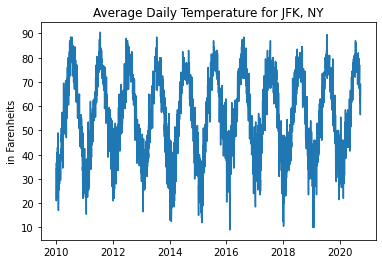

In [8]:
temperature = pd.read_csv('weather.csv', sep ='\t', engine ='python')
temperature['datetime'] = pd.to_datetime(temperature['datetime'])
plt.plot(temperature['datetime'], temperature['temp_average'])
plt.title('Average Daily Temperature for JFK, NY');
plt.ylabel('in Farenheits');

I'll do a quick forecasting on average daily temperature using FBProphet. <br>
Training set was 2010-2017, Testing set: 2018-2020

In [9]:
_temperature = date_features(temperature.set_index('datetime')[['temp_average']])
_fb_weather = _temperature.reset_index()[['datetime', 'temp_average']]
_fb_weather.columns = ['ds', 'y']
_fb_weather.head()

,ds,y
0,2010-01-01,36.5
1,2010-01-02,25.0
2,2010-01-03,21.0
3,2010-01-04,26.0
4,2010-01-05,26.5


In [10]:
m = Prophet(
           changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 300,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
m.fit(_fb_weather)

In [11]:
future = m.make_future_dataframe(periods = 365*2)
forecast = m.predict(future)

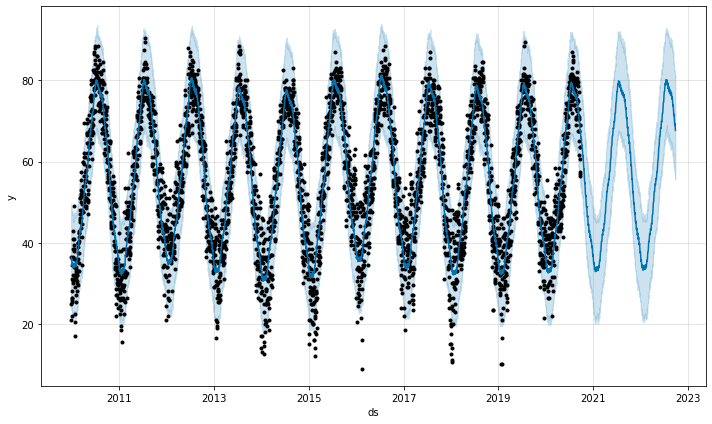

In [12]:
fig1 = m.plot(forecast)

In [13]:
sliced_forecast = forecast.loc[forecast['ds'].isin(pd.date_range(start='2018-01-01', end='2020-09-26'))]
sliced_forecast.reset_index(drop=True, inplace=True)

In [14]:
sliced_forecast = sliced_forecast[['ds', 'yhat']]
sliced_forecast.columns = ['datetime', 'temp_average']
sliced_forecast.set_index('datetime', inplace=True)
sliced_forecast.head()

,temp_average
datetime,
2018-01-01,34.744700
2018-01-02,35.134029
2018-01-03,34.775099
2018-01-04,34.159110
2018-01-05,33.598794


In [15]:
_df['temp_average'] = sliced_forecast['temp_average']

## Models

### Dummy Regressor
My baseline will be the average of the last 7 days for each bridge.
The sum of the 9 rmse (for each bridge) will be my metric.
I have chosen to use root mean squared error because it is more sensitive to larger errors than MAE(mean absolute error) or MAPE(mean absolute percentage error)

In [16]:
dummy_MA7 = []
for bridge in bridges:
    tr_start,tr_end = '2018-01-01','2020-08-22'
    te_start,te_end = '2020-08-23','2020-09-26'
    tes = _df[te_start:te_end][bridge]
    tra = _df[tr_start:tr_end][bridge]
    _dummy = pd.DataFrame()
    _dummy['datetime'] = pd.date_range(start='2020-08-23', end='2020-09-26')
    _dummy.set_index('datetime', inplace=True)
    _dummy[bridge] = tra.tail(7).mean()
    
    dummy_MA7.append(np.sqrt(mean_squared_error(tes,_dummy)))
    

In [17]:
_results_df = pd.DataFrame()
_results_df['bridges'] = bridges
_results_df['dummy_MA7'] = dummy_MA7
_results_df

,bridges,dummy_MA7
0,Brooklyn Battery,9689.766880
1,Cross Bay,3058.987092
2,Henry Hudson,7491.891404
3,Marine Parkway,4298.716057
4,Queens Midtown,9678.803759
5,Throgs Neck,7107.930655
6,Triboro,12989.973539
7,Verrazano,6814.856433
8,Whitestone,7821.773825


In [18]:
_results_df.sum(axis=0)

bridges      Brooklyn BatteryCross BayHenry HudsonMarine Pa...
dummy_MA7                                              68952.7
dtype: object

### SARIMAX
I will use the features created from above as my independent exogenous variables. <br>
the values (p,d,q)x(P,D,Q,m), and trend was found through grid searching. <br>

I have used m=7 because the data points are daily.

### One Hot Encoder
After all features have been created, I will need to dummify the categorical features for SARIMAX.

In [35]:
ohe = OneHotEncoder(drop='first')
categorical_columns = ['month', 'dayofweek', 'quarter', 'Phase']
_df_ohe = ohe.fit_transform(_df[categorical_columns]).toarray()
_df_ohe_df = pd.DataFrame(data = _df_ohe,
                           index = _df.index,
                          columns = ohe.get_feature_names(categorical_columns))

_df_merged = _df.merge(_df_ohe_df, left_index=True, right_index=True)
_df_ohe_df['weekend'] = _df['weekend']
_df_ohe_df['holiday'] = _df['holiday']
_df_ohe_df['temp_average'] = _df['temp_average']
_df_ohe_df.shape

(1000, 28)

In [36]:
def return_sarimax_rmse(bridge, _order, _seasonal_order, _trend):
    """
    returns arima rmse
    """
    tr_start,tr_end = '2018-01-01','2020-08-22'
    te_start,te_end = '2020-08-23','2020-09-26'
    tra = _df_merged[tr_start:tr_end][bridge]
    tes = _df_merged[te_start:te_end][bridge]
    exog_train = _df_ohe_df[tr_start:tr_end]
    exog_test = _df_ohe_df[te_start:te_end]
    
    model_SARIMAX = SARIMAX(tra, order=_order, seasonal_order= _seasonal_order, exog = exog_train, trend = _trend,
                        freq='D', enforce_stationarity=False, enforce_invertibility=False)
    results = model_SARIMAX.fit(maxiter=1000)
    
    pred = results.predict(te_start,te_end, exog = exog_test)
    return np.sqrt(mean_squared_error(tes,pred))

### Grid Search
I took this technique from machine learning mastery. It brute forces the combinations. <br>
I have set m = 7 because this is daily data. <br>
The selected params were (1,1,2)x(1,0,1,7) trend='n'


In [37]:
# code was taken from machine learning mastery
models = list()
p_params = [0, 1, 2]
d_params = [0, 1]
q_params = [0, 1, 2]
t_params = ['n','c','t','ct']
P_params = [0, 1, 2]
D_params = [0, 1]
Q_params = [0, 1, 2]
m_params = [7]
# create config instances
for p in p_params:
    for d in d_params:
        for q in q_params:
            for t in t_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            for m in m_params:
                                cfg = [(p,d,q), (P,D,Q,m), t]
                                models.append(cfg)


In [38]:
# # This grid search took around 40 hours. Please don't run this.
# _grid_sarimax = []
# for model in tqdm(models):
#     _each_grid = []
#     for i in bridges:
#         _each_grid.append(return_sarimax_rmse(i, model[0], model[1], model[2]))
#     print((sum(l7), model))
#     _grid_sarimax.append((sum(l7), model))

In [39]:
# Please note, I fit a sarimax model for each of the 9 bridges and returned an rmse from the test set.
# I should have 9 rmse (one for each bridge), the summation of the rmse will be the final metric.


_sarimax_rmse = []
for i in tqdm(bridges):
    _sarimax_rmse.append(return_sarimax_rmse(i, (1,1,2), (1,0,1,7), 'n'))

100%|██████████| 9/9 [01:12<00:00,  8.05s/it]


In [40]:
_results_df['SARIMAX'] = _sarimax_rmse
_results_df

,bridges,dummy_MA7,SARIMAX
0,Brooklyn Battery,9689.766880,3822.820778
1,Cross Bay,3058.987092,3038.119320
2,Henry Hudson,7491.891404,4056.166573
3,Marine Parkway,4298.716057,4266.591402
4,Queens Midtown,9678.803759,3589.698492
5,Throgs Neck,7107.930655,6982.874733
6,Triboro,12989.973539,8794.848155
7,Verrazano,6814.856433,3231.874694
8,Whitestone,7821.773825,5680.295668


In [42]:
_results_df.sum(axis=0)

bridges      Brooklyn BatteryCross BayHenry HudsonMarine Pa...
dummy_MA7                                              68952.7
SARIMAX                                                43463.3
dtype: object

### FBProphet
After implement SARIMAX, I will now move on to FBProphet. <br>
Please note, the FBProphet was not hyperturned

In [28]:
def return_prophet_rmse(bridge):
    tr_start,tr_end = '2018-01-01','2020-08-22'
    te_start,te_end = '2020-08-23','2020-09-26'
    tra = _df_merged[tr_start:tr_end][[bridge]]
    tes = _df_merged[te_start:te_end][[bridge]]
    _fb_exog = _df_merged[['month', 'dayofweek', 'quarter',
           'Phase', 'weekend', 'holiday', 'temp_average']]

    tra = tra.join(_fb_exog)
    tes = tes.join(_fb_exog)


    exog_train = _df_ohe_df[tr_start:tr_end]
    exog_test = _df_ohe_df[te_start:te_end]
    tra = tra.reset_index()
    tra = tra.rename(columns = {bridge:'y', 'datetime': 'ds'})
    tes = tes.reset_index()
    tes = tes.rename(columns = {bridge:'y', 'datetime': 'ds'})


    m = Prophet(
           changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 300,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
    for i in _fb_exog.columns:
        m.add_regressor(i)


    m.fit(tra)
    
    # Please change the periods after changing the te_start and te_end. For this case i have made periods 35 because there are 35 days on the the test set.
    future = m.make_future_dataframe(periods=35)
    future.set_index('ds', inplace=True)
    future = future.join(_fb_exog)
    future.reset_index(inplace=True)
    pred = m.predict(future[-35:])
    return np.sqrt(mean_squared_error(tes['y'],pred['yhat']))

In [29]:
fb_prophet_1 = []
for i in tqdm(bridges):
    fb_prophet_1.append(return_prophet_rmse(i))
    
_results_df['FB_prophet_1'] = fb_prophet_1
_results_df

100%|██████████| 9/9 [04:50<00:00, 32.30s/it]


,bridges,dummy_MA7,SARIMAX,FB_prophet_1
0,Brooklyn Battery,9689.766880,3800.422075,4146.735600
1,Cross Bay,3058.987092,3038.366098,2881.517478
2,Henry Hudson,7491.891404,4013.042613,3873.400612
3,Marine Parkway,4298.716057,4266.804149,4428.792730
4,Queens Midtown,9678.803759,3593.463138,9071.725197
5,Throgs Neck,7107.930655,7021.236084,5813.764461
6,Triboro,12989.973539,8760.379990,7645.789449
7,Verrazano,6814.856433,3236.013288,3338.660881
8,Whitestone,7821.773825,5738.769982,6497.563062


In [30]:
_results_df.sum(axis=0)

bridges         Brooklyn BatteryCross BayHenry HudsonMarine Pa...
dummy_MA7                                                 68952.7
SARIMAX                                                   43468.5
FB_prophet_1                                              47697.9
dtype: object

### LightGBM
After using tuned SARIMAX and a more-or-less generic FBProphet, I thought it was a good opportunity to try changing the time series problem into a decision tree regression problem. Instead of having 9 separate models for each bridge, we can have 1 GBDT model. This is done by first melting all the columns and making the dataframe long. As I have created features in the SARIMAX and FBProphet models, I will do the same here.

In [16]:
_df = df.unstack().T
_df = _df['2018':].copy()
for i in _df.columns:
    _df[i] = _df[i].replace(to_replace=0, method='ffill')
_df.reset_index(inplace=True)

In [17]:
# I need to make the dataframe from wide to long. This can be done through pandas melt.
_df_melt = pd.melt(_df, id_vars=['datetime'], value_vars=['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway', 
                                                        'Queens Midtown', 'Throgs Neck', 'Triboro', 'Verrazano', 'Whitestone'])
_df_melt.set_index('datetime', inplace=True)

In [18]:
# LGBM doesn't take the string form in categorical values
le = LabelEncoder()
_df_melt['plaza_id'] = le.fit_transform(_df_melt['plaza_id'])

In [19]:
_df_melt = date_features(_df_melt)

_df_melt = _df_melt.join(sliced_forecast)
# There are many instances where I'll set an index to datetime and reset it.
# This is my fault for not making the data preprocessing functions take the same columns. For example: date_features takes index, while date_lag takes the column
_df_melt.reset_index(inplace=True)

In [38]:
# Creating 3 sliced dataframes
train_set = _df_melt.loc[_df_melt['datetime'] <= '2020-08-22'].copy(deep=True)
test_set = _df_melt.loc[(_df_melt['datetime'] > '2020-08-22') & (_df_melt['datetime'] <= '2020-09-26')].copy(deep=True)
pred_set = _df_melt.loc[(_df_melt['datetime'] > '2020-08-22')].copy(deep=True)
pred_set['value'] = np.nan
pred_set.tail()

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday,temp_average
8995,2020-09-26,4,NaN,9,5,2020,39,26,3,270,7,1,0,65.793937
8996,2020-09-26,5,NaN,9,5,2020,39,26,3,270,7,1,0,65.793937
8997,2020-09-26,6,NaN,9,5,2020,39,26,3,270,7,1,0,65.793937
8998,2020-09-26,7,NaN,9,5,2020,39,26,3,270,7,1,0,65.793937
8999,2020-09-26,8,NaN,9,5,2020,39,26,3,270,7,1,0,65.793937


In [39]:
def date_lags(_df):
    """
    creates lag 7 and lag 28 features from values.
    creates ma7_lag7, ma7_lag28, ma28_lag7, ma28_lag28.
    
    """
    
#     _df['lag_1'] = _df[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(1)
    
    
    _df['lag_7'] = _df[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(7)
    _df['lag_28'] = _df[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(28)

    
    
    _df['mean_lag7_roll7'] = _df[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].apply(lambda x: x.rolling(7).mean())
    _df['mean_lag7_roll28'] = _df[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].apply(lambda x: x.rolling(28).mean())
    _df['mean_lag28_roll7'] = _df[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].apply(lambda x: x.rolling(7).mean())
    _df['mean_lag28_roll28'] = _df[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].apply(lambda x: x.rolling(28).mean())
    _df['week'] = _df['week'].astype('int64')
    
    return _df

In [40]:
train_set = date_lags(train_set)
train_set.tail()

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday,temp_average,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
8680,2020-08-22,4,54254,8,5,2020,34,22,3,235,7,1,0,75.33398,51273.0,49092.0,60339.857143,57472.714286,55335.714286,52549.535714
8681,2020-08-22,5,121123,8,5,2020,34,22,3,235,7,1,0,75.33398,119610.0,102764.0,107722.142857,104736.392857,105834.142857,104777.214286
8682,2020-08-22,6,151278,8,5,2020,34,22,3,235,7,1,0,75.33398,150398.0,149966.0,157007.714286,153342.750000,152022.000000,146932.928571
8683,2020-08-22,7,96748,8,5,2020,34,22,3,235,7,1,0,75.33398,97799.0,92065.0,98406.285714,94290.785714,92764.000000,91358.250000
8684,2020-08-22,8,128905,8,5,2020,34,22,3,235,7,1,0,75.33398,132275.0,129053.0,127259.428571,121441.714286,117457.714286,111727.500000


In [41]:
categorical_features = ['plaza_id', 'month', 'dayofweek', 'week', 'day', 'Phase', 'weekend', 'holiday']
useless_cols = ['datetime', 'value', 'year']
train_cols = [x for x in train_set.columns if x not in useless_cols]
_X = train_set[train_cols]
_y = train_set['value']

In [42]:
# train test split
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, random_state=42, test_size=0.2)

In [43]:
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=categorical_features, free_raw_data=False)
y_valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature=categorical_features, free_raw_data=False) 


#### Optuna
Optuna looks very similiarly to randomized Search CV. More importantly, it displays a progress bar and results paramter after each iteration. <br> I decided to use this to find the best parameters.

In [44]:
def objective(trial):
    params = {
        'objective': 'poisson',
        'boosting': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 18, 56),
        'num_leaves': trial.suggest_int('num_leaves', 36, 98),
        'metric' :'rmse',

        'learning_rate' : 0.05,


        'bagging_fraction' : trial.suggest_loguniform('bag_frac', 0.5, 0.9),
        'feature_fraction': trial.suggest_loguniform('feat_frac', 0.5, 0.9),
        'lambda_l1' : trial.suggest_loguniform('l1', 0.1, 0.9),
        'lambda_l2' : trial.suggest_loguniform('l2', 0.1, 0.9),

        'verbosity': 1}


    m_lgb = lgb.train(params, train_data,num_boost_round=20000, valid_sets = y_valid_data, verbose_eval=100, early_stopping_rounds=500)
    
    train_roll = train_set.copy(deep=True)
    try:
        for i in tqdm(range(1,500)):
            _to_pred = pred_set.loc[pred_set['datetime'] == (datetime.datetime(2020, 8, 22) + datetime.timedelta(days= i))].copy()
            _first_concat = pd.concat([train_roll, _to_pred])
            _first_concat.reset_index(inplace=True, drop=True)
            _first_concat = date_lags(_first_concat)
            _to_pred = _first_concat.loc[_first_concat['datetime'] == (datetime.datetime(2020, 8, 22) + datetime.timedelta(days= i))].copy()
            _to_pred_feats = _to_pred[train_cols]
            first_pred = m_lgb.predict(_to_pred_feats)
            _to_pred['value'] = first_pred
            train_roll = pd.concat([train_roll, _to_pred])
    except:
        print('end of loop')
    
    _lgbm_pred = train_roll.loc[train_roll['datetime'].isin(pd.date_range('2020-08-23', '2020-09-26'))][['datetime', 'plaza_id', 'value']]
    _lgbm_pred['plaza_id'] = le.inverse_transform(_lgbm_pred['plaza_id'])
    _lgbm_pivot_pred = _lgbm_pred.pivot(index='datetime', columns='plaza_id', values='value')
    test_set_pivot = test_set.pivot(index='datetime', columns = 'plaza_id', values='value')
    test_set_pivot.columns = bridges
    
        
    _lgbm_rmse = []
    for i in bridges:
        _lgbm_rmse.append(np.sqrt(mean_squared_error(test_set_pivot[i], _lgbm_pivot_pred[i])))

    
    return sum(_lgbm_rmse)

In [43]:
# 100 trials: this can take a while, feel free to interrupt at any time
# study = optuna.create_study()
# study.optimize(objective, n_trials=100)

In [43]:
params = {
    'objective': 'poisson',
    'boosting': 'gbdt',
    'max_depth': 38,
    'num_leaves': 83,
    'metric' :'rmse',
    'learning_rate' : 0.05,

    'bagging_fraction' : 0.5163386620025411,
    'feature_fraction': 0.8282029364551513,
    'lambda_l1' : 0.32608335857159515,
    'lambda_l2' : 0.47993551029860304,
    'verbosity': 1

}
# params taken from optuna
# {'max_depth': 38, 'num_leaves': 83, 'bag_frac': 0.5163386620025411, 'feat_frac': 0.8282029364551513, 'l1': 0.32608335857159515, 'l2': 0.47993551029860304}

In [44]:
m_lgb = lgb.train(params, train_data,num_boost_round=20000, valid_sets = y_valid_data, verbose_eval=100, early_stopping_rounds=500)

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 10553.7
[200]	valid_0's rmse: 8615.48
[300]	valid_0's rmse: 7708.89
[400]	valid_0's rmse: 7222.14
[500]	valid_0's rmse: 7002.11
[600]	valid_0's rmse: 6886.82
[700]	valid_0's rmse: 6820
[800]	valid_0's rmse: 6782.45
[900]	valid_0's rmse: 6757.08
[1000]	valid_0's rmse: 6718.79
[1100]	valid_0's rmse: 6701.09
[1200]	valid_0's rmse: 6686.42
[1300]	valid_0's rmse: 6677.65
[1400]	valid_0's rmse: 6676.29
[1500]	valid_0's rmse: 6675.4
[1600]	valid_0's rmse: 6672.27
[1700]	valid_0's rmse: 6667.06
[1800]	valid_0's rmse: 6664.68
[1900]	valid_0's rmse: 6664.75
[2000]	valid_0's rmse: 6662.29
[2100]	valid_0's rmse: 6660.42
[2200]	valid_0's rmse: 6660.02
[2300]	valid_0's rmse: 6661.52
[2400]	valid_0's rmse: 6660.73
[2500]	valid_0's rmse: 6660.89
[2600]	valid_0's rmse: 6660.2
[2700]	valid_0's rmse: 6660.23
Early stopping, best iteration is:
[2228]	valid_0's rmse: 6659.55


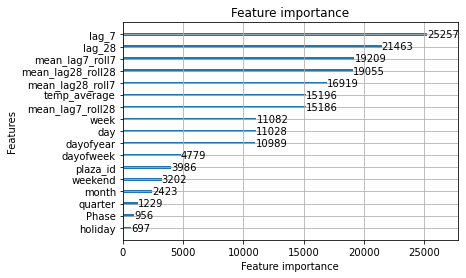

In [45]:
lgb.plot_importance(m_lgb)

In [46]:
train_roll = train_set.copy(deep=True)
try:
    for i in tqdm(range(1,500)):
        _to_pred = pred_set.loc[pred_set['datetime'] == (datetime.datetime(2020, 8, 22) + datetime.timedelta(days= i))].copy()
        _first_concat = pd.concat([train_roll, _to_pred])
        _first_concat.reset_index(inplace=True, drop=True)
        _first_concat = date_lags(_first_concat)
        _to_pred = _first_concat.loc[_first_concat['datetime'] == (datetime.datetime(2020, 8, 22) + datetime.timedelta(days= i))].copy()
        _to_pred_feats = _to_pred[train_cols]
        first_pred = m_lgb.predict(_to_pred_feats)
        _to_pred['value'] = first_pred
        train_roll = pd.concat([train_roll, _to_pred])
except:
    print('end of loop')

  7%|▋         | 35/499 [00:02<00:28, 16.21it/s]


end of loop


In [47]:
_lgbm_pred = train_roll.loc[train_roll['datetime'].isin(pd.date_range('2020-08-23', '2020-09-26'))][['datetime', 'plaza_id', 'value']]
# _lgbm_pred
_lgbm_pred['plaza_id'] = le.inverse_transform(_lgbm_pred['plaza_id'])
_lgbm_pivot_pred = _lgbm_pred.pivot(index='datetime', columns='plaza_id', values='value')
test_set_pivot = test_set.pivot(index='datetime', columns = 'plaza_id', values='value')
test_set_pivot.columns = bridges

In [48]:
_lgbm_rmse = []
for i in bridges:
    _lgbm_rmse.append(np.sqrt(mean_squared_error(test_set_pivot[i], _lgbm_pivot_pred[i])))
_results_df['LGBM'] = _lgbm_rmse
display(_results_df.sum(axis=0))
_results_df

bridges         Brooklyn BatteryCross BayHenry HudsonMarine Pa...
dummy_MA7                                                 68952.7
SARIMAX                                                   43468.5
FB_prophet_1                                              47697.9
LGBM                                                      44943.7
dtype: object

,bridges,dummy_MA7,SARIMAX,FB_prophet_1,LGBM
0,Brooklyn Battery,9689.766880,3800.422075,4146.735600,3909.244097
1,Cross Bay,3058.987092,3038.366098,2881.517478,3008.644669
2,Henry Hudson,7491.891404,4013.042613,3873.400612,3942.044990
3,Marine Parkway,4298.716057,4266.804149,4428.792730,3942.005070
4,Queens Midtown,9678.803759,3593.463138,9071.725197,4129.801764
5,Throgs Neck,7107.930655,7021.236084,5813.764461,7693.743703
6,Triboro,12989.973539,8760.379990,7645.789449,7657.774863
7,Verrazano,6814.856433,3236.013288,3338.660881,4430.386676
8,Whitestone,7821.773825,5738.769982,6497.563062,6230.082334


In [49]:
_results_df.sum(axis=0)

bridges         Brooklyn BatteryCross BayHenry HudsonMarine Pa...
dummy_MA7                                                 68952.7
SARIMAX                                                   43468.5
FB_prophet_1                                              47697.9
LGBM                                                      44943.7
dtype: object

# Best Model Forward: SARIMAX
LGBM previously performed the best out of the three.... things have changed but I will forecast using LGBM. <br>
LGBM performed the best out of the three. On the next notebook, I will refit the model off the entire dataset and predict up to March-31-2021. <br>
In addition, I'll change some of the phases on January-1-2021:
1. Phase -1: Coronavirus is over, return back to normal
2. Phase 4: Continue with Phase 4
3. Phase 1: Lockdown and reopen on February-01-2021